In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'+'nue_check/' 
output_filedir = outputdir
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [3]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

# Nue cross check
The filter must pass fewer than 45 electron neutrino events normalized to 6.6E20 POT
counted within a range of true neutrino energy between 50 MeV to 1.5 GeV using a
sample of ~300,000 cosmic-overlaid charged current electron neutrino interactions in the
TPC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"nue_check.root","RECREATE");
filename_overlay = 'NuCCana_nue_V26.root'
tree_name = 'numuCCAna'

overlay = ROOT.TChain(tree_name + "/event","event")
overlay.Add( inputdir + filename_overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
print 'POT: ',pot_overlay

POT:  1.3830285635e+20


In [5]:
filename_overlay = filename_overlay+'out4.root'
tree_name = 't_out'

overlay_out = ROOT.TChain(tree_name, "t_out")
overlay_out.Add( inputdir + filename_overlay)

print 'Entries TTree: ',overlay.GetEntries()
print 'Entries Tout: ',overlay_out.GetEntries()

Entries TTree:  130980
Entries Tout:  130979


In [6]:
fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
overlay.SetAlias('fidVol',fidVol)
overlay_out.SetAlias('fidVol',fidVol)
overlay.SetAlias('muon','(track_key == key_muon)')
overlay_out.SetAlias('muon','(track_key == key_muon)')

track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'
track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'

overlay.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)

overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

overlay.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [12]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
this_cut = ' && MCNu_PDG==12 && MCNu_Energy<1.5 && MCNu_Energy>0.05'
nue_pass_rate = overlay_out.GetEntries(cut+this_cut)
print 'Nues passing cut: ', nue_pass_rate


Nues passing cut:  5924


Entries 5924.0


Warning in <TFile::Append>: Replacing existing TH1: h_temp (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file h_temp.root has been created
Info in <TCanvas::Print>: png file h_temp.png has been created
Info in <TCanvas::Print>: pdf file h_temp.pdf has been created


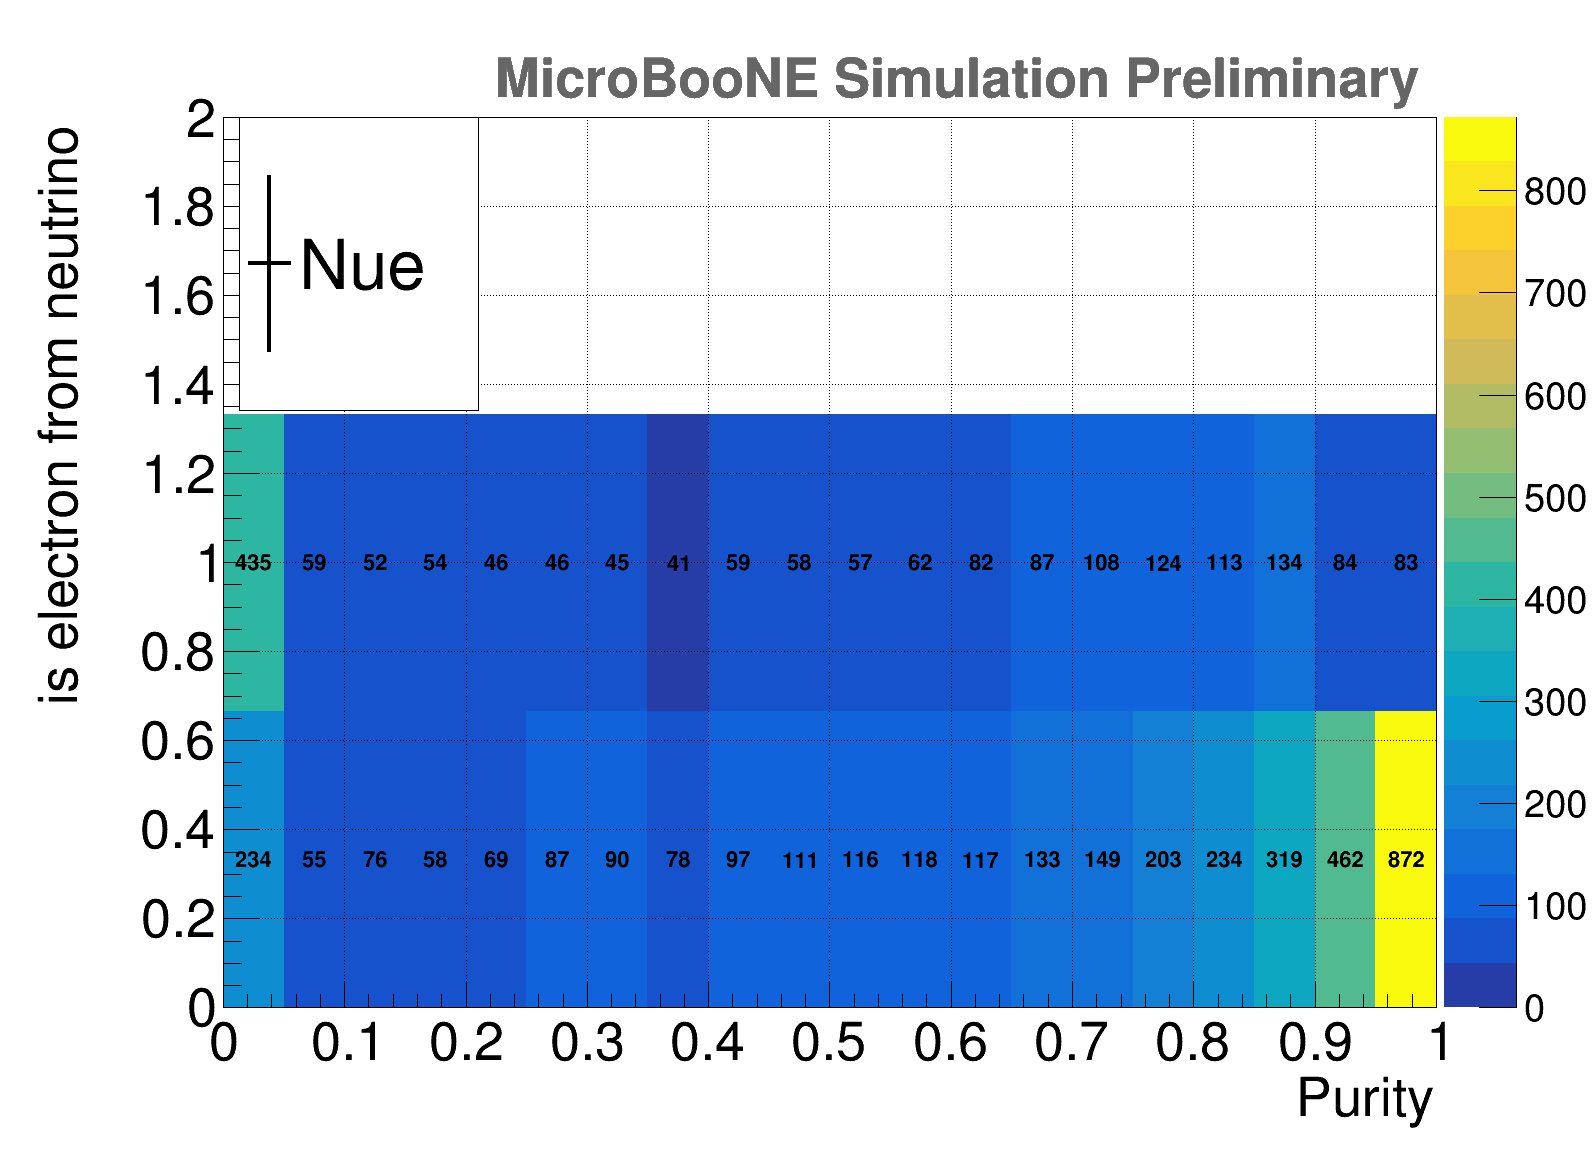

In [36]:
h_temp = ROOT.TH2F("h_temp",'h_temp',20,0,1,3,0,2)
overlay_out.Draw('(MCTrackPDG==11):MCTrackPurity'+'>>h_temp',cut+this_cut,'')
h_temp.SetXTitle("Purity")
h_temp.SetYTitle("is electron from neutrino")
h_temp.GetYaxis().SetTitleSize(0.05)
h_temp.GetYaxis().SetTitleOffset(1.3)
h_temp.GetYaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleSize(0.05)
h_temp.GetXaxis().SetLabelSize(0.05)
h_temp.GetXaxis().SetTitleOffset(1)
h_temp.SetLineColor(ROOT.kBlack)
h_temp.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_temp.Draw('colz text')
prelim = draw_sim()
prelim.Draw()
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
legend.AddEntry(h_temp,'Nue',"lep");
legend.Draw()
print "Entries", h_temp.GetEntries()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h_temp.root")
c1.SaveAs(globale.outputdir_png + "h_temp.png")
c1.SaveAs(globale.outputdir_pdf + "h_temp.pdf")

fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1


12954

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_migration_r (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file h2_true_MCS.pdf has been created


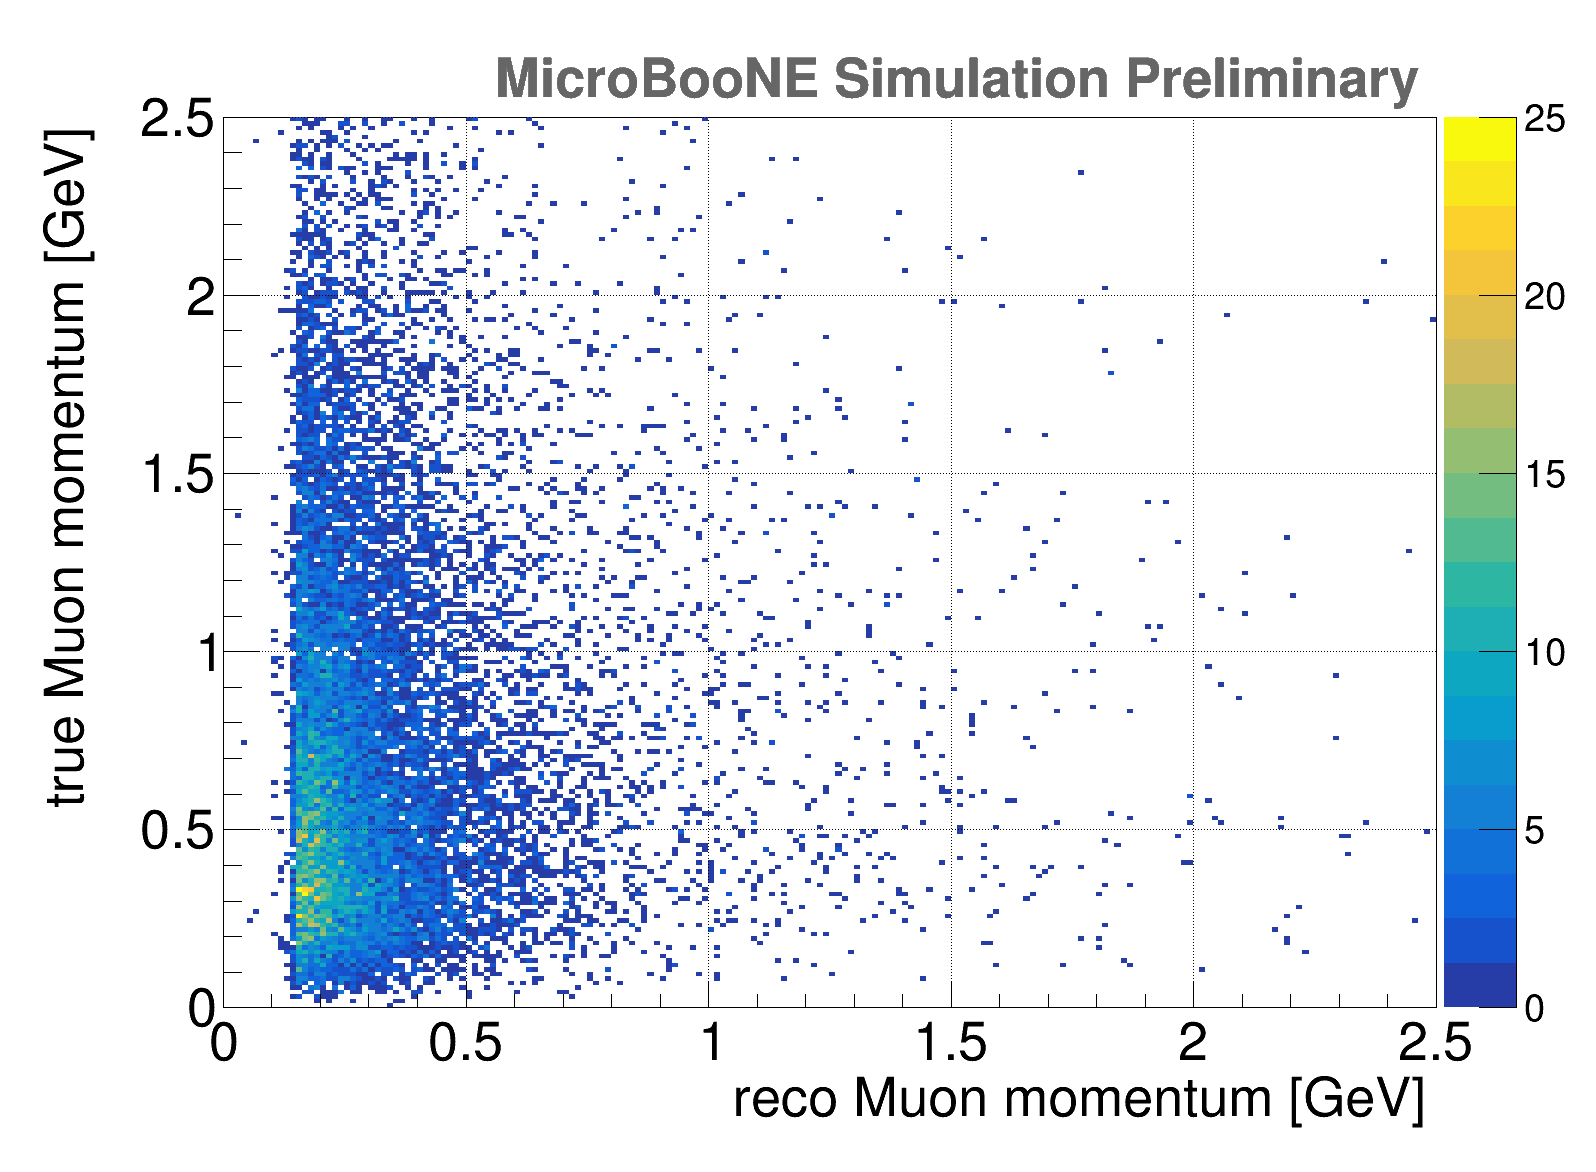

In [35]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

In [ ]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
h_migration_r = ROOT.TH2F("h_migration_r",'Truth vs. Reco',200,0,2.5,200,0,2.5)
print cut
overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',cut+' && track_end_uncontained','')
overlay_out.Draw('MCle_Energy:TrackMomRange_mu'+'>>h_migration_r',cut+'&& !track_end_uncontained','')
h_migration.Add(h_migration_r)
h_migration.SetXTitle("reco Muon momentum [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")